# It Pays to Stay | Automating Customer Experience at Telco
<b>Final Report</b><br>
Stephanie Jones<br>
Codeup | Hopper, Data Science<br>
Monday, November 28, 2021

# 01_acquire
## To acquire the Telco data, I used the 'telco_churn' db in our mySQL server, and selected all columns from customers table `select * from customers`
joining the following tables:
- contract_types using (contract_type_id) `join contract_types using (contract_type_id)`
- internet_service_types using (internet_service_type_id) `join internet_service_types using (internet_service_type_id)`
- payment_types using (payment_type_id)`join payment_types using (payment_type_id)`

In [1]:
import acquire # this is the file with all of the functions used to connect to db and acquire Telco data

# this will run the function that:
#     connects to the db using credentials from env file
#     runs the SQL query and writes a pandas DataFrame from the results
#     caches the DataFrame into a local telco_data.csv file if one does not already exist

raw_data = acquire.acquire_telco_data()

# 02_prepare

## To prepare the Telco data for exploration and modeling, I used the raw_telco data and did the following:
#### a. Drop unecessary columns 
`'total_charges'`, `'customer_id'`, `'multiple_lines'`, `'online_security'`, `'online_backup'`, `'device_protection'`, 
    `'streaming_tv'`, `'tech_support'`, `'streaming_movies'`,  `'contract_type'`, `'internet_service_type'`,`'payment_type'`
#### b. Map binary, yes/no to 1/0 
`'partner'`, `'dependents'`,`'phone_service'`,`'tech_support'`,`'paperless_billing'`,`'churn'`
#### c. Map gender column male/female to 1/0
`gender`
#### d. split the data
>a. split the cleaned telco data, first into train_and_validate (80%) and test (20%)<br>
b. splt the train_and_validate into train (70% of the 80%, 56% of the total) and validate (30% of the 80%, 24% of the total)

In [2]:
import prepare # this is the file with all of the functions used to clean and split the raw Telco data

train, validate, test = prepare.prep_telco(raw_data)

# 03_Explore
## Initial Questions
1. Do customers who pay a certain way churn more?
2. Do customers with a certain type of internet service churn more?
3. Do customers with lower monthly charges churn less than those with higher monthly charges?

### Q1. Do customers who pay a certain way churn more?
>1: eCheck<br>
2: Mail<br>
3: Bankxfer_auto<br>
4: Credit_auto

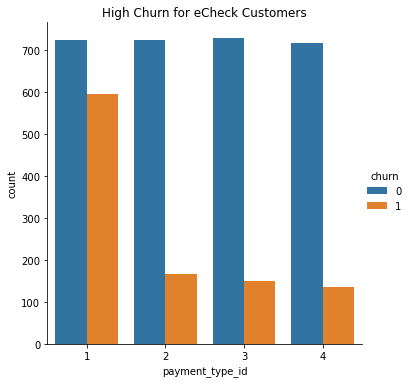

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(x="payment_type_id", hue = 'churn', kind = 'count', data=train)
plt.title('High Churn for eCheck Customers')
plt.show()

### Q2. Do customers with a certain type of internet service churn more?
>1: DSL<br>
2: Fiber<br>
3: None<br>

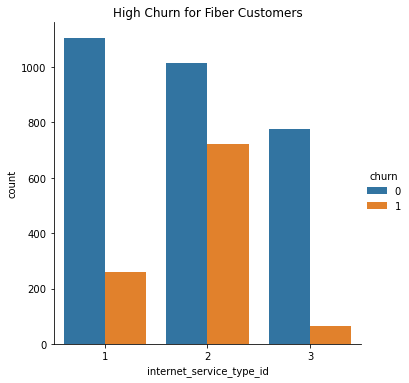

In [4]:
sns.catplot(x="internet_service_type_id", hue = 'churn', kind = 'count', data=train)
plt.title('High Churn for Fiber Customers')
plt.show()

### Q3. Do customers with higher monthly charges have lower tenures?

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

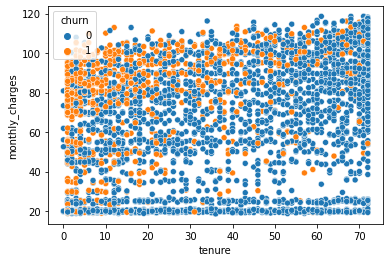

In [9]:
sns.scatterplot(x='tenure', y='monthly_charges', data=train, hue = 'churn')

### Hypothesis Test
>alpha = .05<br>
H(o): Customers who churn have higher or equal tenures than those who do not<br>
H(a): Customers who churn have lower tenures than those who do not churn

#### Setting up t-test to determine if customers who churn have lower tenures than those who do not

In [28]:
from math import sqrt
from scipy import stats
import statistics

churn_sample = train[train.churn == 1].tenure
no_churn_sample = train[train.churn == 0].tenure

print(f'churn sample variance: {churn_sample.var()}')
print(f'no churn sample variance: {no_churn_sample.var()}')
print()

alpha = .05
t, p = stats.ttest_ind(churn_sample, no_churn_sample, equal_var = False)
print(f't = {t}')
print(f'p = {p}')
print(f'alpha = .05')

churn sample variance: 388.47514340344014
no churn sample variance: 573.891555276271

t = -25.874039836231177
p = 2.7049588267426267e-129
alpha = .05


In [22]:
if p/2 > alpha:
    print("We fail to reject H(o)")
elif t < 0:
    print("We fail to reject H(o)")
else:
    print("We reject H(o)")

We fail to reject H(o)


### Takeaways from Explore
1. Do customers who pay a certain way churn more?
>Customers who pay by eCheck have highest churn

2. Do customers with a certain type of internet service churn more?
>Customers with Fiber have highest churn<br>
Customers with no internet service have lowest churn

3. Do customers with lower monthly charges churn less than those with higher monthly charges?
>There is not much correlation between monthly charges and tenure<br>
Most of our customers who are churning have high monthly_charges and churning earlier in tenure<br>
The higher a customer’s tenure the less likely they are to churn

# 04_model

In [88]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train[['payment_type_id', 'tenure']]
y_train = train.churn

X_validate = validate[['payment_type_id', 'tenure']]
y_validate = validate.churn

X_test = test[['payment_type_id', 'tenure']]
y_test = test.churn

In [89]:
from sklearn.ensemble import RandomForestClassifier

baseline = y_train.mode()
matches_baseline_pred = (y_train == 0)
baseline_accuracy = matches_baseline_pred.mean( )
print(f'Baseline Accuracy: {round( baseline_accuracy, 2 )}')

Baseline Accuracy: 0.73


In [90]:
from sklearn.tree import DecisionTreeClassifier

# create model object
clf_2 = DecisionTreeClassifier(max_depth=2, random_state=123)

# fit model
clf_2 = clf_2.fit(X_train, y_train)

# predictions
y_pred_2 = clf_2.predict(X_train)

# model_1 accuracy
print('Accuracy of Model 1 Decision Tree classifier on training set: {:.2f}'.format(clf_2.score(X_train, y_train)))

Accuracy of Model 1 Decision Tree classifier on training set: 0.77


In [91]:
# create model object
clf_4 = DecisionTreeClassifier(max_depth=4, random_state=123)

# fit model
clf_4 = clf_4.fit(X_train, y_train)

# predictions
y_pred_4 = clf_4.predict(X_train)

# model_1 accuracy
print('Accuracy of Model 2 Decision Tree classifier on training set: {:.2f}'.format(clf_4.score(X_train, y_train)))

Accuracy of Model 2 Decision Tree classifier on training set: 0.77


In [97]:
# create model object
clf_6 = DecisionTreeClassifier(max_depth=6, random_state=123)

# fit model
clf_6 = clf_6.fit(X_train, y_train)

# predictions
y_pred_6 = clf_6.predict(X_train)

# model_1 accuracy
print('Accuracy of Model 3 Decision Tree classifier on training set: {:.2f}'.format(clf_6.score(X_train, y_train)))

Accuracy of Model 3 Decision Tree classifier on training set: 0.78


In [93]:
y_pred_2 = clf_2.predict(X_validate)
print('Accuracy of Model 1 Decision Tree classifier on validate set: {:.2f}'.format(clf_2.score(X_validate, y_validate)))

Accuracy of Model 1 Decision Tree classifier on validate set: 0.76


In [94]:
y_pred_4 = clf_4.predict(X_validate)
print('Accuracy of Model 2 Decision Tree classifier on validate set: {:.2f}'.format(clf_4.score(X_validate, y_validate)))

Accuracy of Model 2 Decision Tree classifier on validate set: 0.76


In [95]:
y_pred_6 = clf_6.predict(X_validate)
print('Accuracy of Model 3 Decision Tree classifier on validate set: {:.2f}'.format(clf_6.score(X_validate, y_validate)))

Accuracy of Model 3 Decision Tree classifier on validate set: 0.77


>Baseline Accuracy: 0.73

>Model 1: Decision Tree with max_depth of 2<br>
Accuracy of Model 1 Decision Tree classifier on training set: 0.77<br>
Accuracy of Model 1 Decision Tree classifier on validate set: 0.76<br>

>Model 2: Decision Tree with max_depth of 4<br>
Accuracy of Model 2 Decision Tree classifier on training set: 0.77<br>
Accuracy of Model 2 Decision Tree classifier on validate set: 0.76<br>

>Model 3: Decision Tree with max_depth of 6<br>
Accuracy of Model 3 Decision Tree classifier on training set: 0.78<br>
Accuracy of Model 3 Decision Tree classifier on validate set: 0.77
# Test on Model 3 Decision Tree

In [96]:
y_pred_6 = clf_6.predict(X_validate)
print('Accuracy of Model 3 Decision Tree classifier on test set: {:.2f}'.format(clf_6.score(X_test, y_test)))

Accuracy of Model 3 Decision Tree classifier on test set: 0.77


# Conclusions, Recommendations, and Next Steps
### Conclusions
>Model 3 Decision Tree with max_depth of 6 is our best performing model on both the training and validate data sets.<br>
Using this model on the final test data set I got an accuracy of 0.77 which outperformed the baseline by 0.03<br>

##### Features driving churn
- Payment Type
- Tenure
### Recommendations
> Incentive existing eCheck customers to switch to auto pay option<br>
> Offer monthly discount promotion for new customers and customers who have joined in last 12mos 